This is Project to learn unsupervised strategy on S&p500 data

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import pandas as pd 
import numpy as np 
import datetime as dt 
import yfinance as yf
import pandas_ta 
import warnings
import requests
warnings.filterwarnings('ignore')
import time
import investpy
from sklearn.cluster import KMeans

Reading and Loading the s&p 500 data

In [2]:
# Ssending HTTP Request
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)

# Reading HTML with pandas
sp500 = pd.read_html(response.text)[1]

sp500


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [3]:
# Preprocessing the symbol names

# Preprocessing to replace periods in symbol names:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbol_list = sp500['Symbol'].unique().tolist()




In [4]:
# Downloading the past 10 years Data for these symbols:
start_date = '2015-01-01'
end_date = '2025-11-09'


# Downloading the Data From Yahoo finance:
df_sp500_orginal = yf.download(tickers=symbol_list, 
                             start=start_date,
                             end=end_date).stack()
df_sp500_orginal.index = df_sp500_orginal.index.set_names(['Date', 'Symbol'])
df_sp500 = df_sp500_orginal.copy()

[*********************100%***********************]  503 of 503 completed


In [28]:
#df_sp500 


#df_sp500 = df_sp500.drop(columns=['Adj Close'])
df_sp500 

Price                   Close        High         Low        Open       Volume
Date       Symbol                                                             
2015-01-02 A        37.120949   37.807357   36.947057   37.688378    1529200.0
           AAPL     24.237551   24.705320   23.798600   24.694235  212818400.0
           ABBV     42.091434   42.417231   41.803970   41.803970    5086100.0
           ABT      36.418674   36.864782   36.207785   36.702560    3216600.0
           ACGL     18.539352   18.884845   18.472788   18.764398    1101600.0
...                       ...         ...         ...         ...          ...
2025-11-07 XYZ      65.449997   66.739998   61.360001   61.360001   21402400.0
           YUM     149.119995  149.410004  147.720001  148.369995    2415500.0
           ZBH      88.500000   90.160004   87.430000   89.000000    2628200.0
           ZBRA    259.540009  259.760010  252.139999  255.800003     777800.0
           ZTS     120.239998  120.269997  117.260002  119.559998    5808800.0

[1326926 rows x 5 columns]

Now we calculate the following indicators

Garman Klass Volatility
RSI
Bollinger bands
ATR
MACD
Dollar Volume

In [29]:
df_sp500['Garman-Klass Volatility'] = (np.log(df_sp500['High']) - np.log(df_sp500['Low']))**2/2 - (2*np.log(2)-1)*(np.log(df_sp500['Close']) - np.log(df_sp500['Open']))**2
df_sp500['Rsi'] = df_sp500.groupby(level=1)['Close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

def safe_bbands(x):
    bb = pandas_ta.bbands(close=np.log1p(x['Close']), length=20)
    if bb is not None and not bb.empty:
        bb = bb.iloc[:, :3]
        bb.columns = ['Bband_low', 'Bband_mid', 'Bband_high']
        return bb
    else:
        return pd.DataFrame(np.nan, index=x.index, columns=['Bband_low', 'Bband_mid', 'Bband_high'])


def atr(x):
    atr = pandas_ta.atr(high=x['High'], low=x['Low'], close=x['Close'], length=14)
    if atr is None or atr.empty:
        return pd.Series(np.nan, index=x.index, name='ATR_14')
    
    # If it's a DataFrame, pick the first column
    if isinstance(atr, pd.DataFrame):
        atr = atr.iloc[:, 0]
    # Make sure it has a name
        atr.name = 'ATR_14'
    atr = atr.sub(atr.mean()).div(atr.std())    
    return pd.DataFrame({'ATR_14': atr})
 


def macd(x):
    macd = pandas_ta.macd(close=x['Close'], length=20)
    if macd is None or macd.empty:
        return pd.Series(np.nan, index=x.index, name='MACD')
    
    # If it's a DataFrame, pick the first column
    if isinstance(macd, pd.DataFrame):
        macd = macd.iloc[:, 0]
    
    # Make sure it has a name
        macd.name = 'MACD'
    return macd.sub(macd.mean()).div(macd.std())



df_sp500 = df_sp500.join(df_sp500.groupby(level=1, group_keys=False).apply(safe_bbands))
df_sp500 = df_sp500.join(df_sp500.groupby(level=1, group_keys=False).apply(atr))
df_sp500 = df_sp500.join(df_sp500.groupby(level=1, group_keys=False).apply(macd))

df_sp500['Dollar_Volume'] = (df_sp500['Volume'] * df_sp500['Close'])/1e6
df_sp500.columns = df_sp500.columns.str.lower() 

## Filtering out the data for model

In [30]:
## Making to monthly aggregation

agr_cols = [c for c in df_sp500.columns if c not in ['open', 'high','low', 'dollar_volume', 'volume']]
data = pd.concat([df_sp500.unstack('Symbol')['dollar_volume'].resample('M').mean().stack('Symbol').to_frame('dollar_volume'),
df_sp500.unstack('Symbol')[agr_cols].resample('M').last().stack('Symbol')], axis=1).dropna()


In [31]:
data['dollar_volume'] = data.loc[:, 'dollar_volume'].unstack('Symbol').rolling(12).mean().stack()
data['dollar_volume_rank'] = data.groupby(level='Date')['dollar_volume'].rank(ascending=False)
data = data[data['dollar_volume_rank']<150].drop(['dollar_volume', 'dollar_volume_rank'], axis=1)


## Calculating changes

In [32]:
def calculate_return(df):
    outlier = .005
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        df[f'return_{lag}m'] = df['close'].pct_change(lag).pipe(lambda x: x.clip(lower = x.quantile(outlier), upper = x.quantile(1-outlier))
                                                                .add(1).pow(1/lag).sub(1))
    return df



data = data.groupby(level = 1, group_keys=False).apply(calculate_return)
    

## Fama French Factor and further Filtering

In [33]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=2016)[0].drop('RF',axis=1)
factor_data.index = pd.to_datetime(factor_data.index.to_timestamp())
factor_data = factor_data.resample('M').last().div(100)
factor_data = factor_data.join(data['return_1m']).sort_index()

In [34]:
data_size = factor_data.groupby(level=1).size()
valid_symbol = data_size[data_size>10]
factor_data = factor_data[factor_data.index.get_level_values('Symbol').isin(valid_symbol.index)]

# Calculating the rolling factor betas

In [35]:
betas = factor_data.groupby(level=1, group_keys=False).apply(lambda x: RollingOLS(endog=x['return_1m'], exog=sm.add_constant(x.drop('return_1m', axis=1)), window=min(24,x.shape[0]),
            min_nobs=len(x.columns)+1).fit(params_only=True).params.drop('const', axis=1))
                        

In [36]:
# Joining to the rest of the data by accounting for on emonth shift that results from time delay of gatherign the data:

data = data.join(betas.groupby(level='Symbol').shift())


In [37]:
factor_list = ['Mkt-RF',	'SMB',	'HML',	'RMW',	'CMA']
data.loc[:, factor_list].groupby('Symbol', group_keys=False)[factor_list].apply(lambda x: x.fillna(x.mean()))

Mkt-RF       SMB       HML       RMW       CMA
Date       Symbol                                                  
2016-01-31 AAPL    1.071447 -0.053473 -0.527657  0.618923 -0.353524
           ABBV    0.676610  0.130516  0.169702 -0.220890  0.098368
           ABT     0.915694 -0.202388 -0.407227 -0.062209  0.779579
           ACN     1.120799 -0.138295 -0.240879  0.027449 -0.074797
           ADBE    1.151250 -0.423301 -0.100926 -0.200636 -1.027088
...                     ...       ...       ...       ...       ...
2025-11-30 WDC     1.261047  0.484433  0.018836 -0.841569 -1.314916
           WFC     1.139085 -0.121932  1.236852 -0.810150 -0.308089
           WMT     0.756011 -0.365326 -0.257186  0.638529  0.524828
           XOM     1.004446  0.178910  0.398085 -0.148257  0.830716
           XYZ     2.287907  0.633220 -0.173504 -2.298512 -0.668575

[17731 rows x 5 columns]

In [38]:
#data = data.drop(['close', 'currency'], axis=1)
data = data.drop(['close'], axis=1)
data

garman-klass volatility        rsi  bband_low  bband_mid  \
Date       Symbol                                                             
2016-01-31 AAPL                   0.000214  41.477745   3.084911   3.146696   
           ABBV                   0.000316  45.787283   3.580226   3.650725   
           ABT                    0.000135  35.617544   3.469137   3.550358   
           ACN                    0.000100  54.939407   4.431278   4.470719   
           ADBE                   0.000410  49.039422   4.448019   4.499281   
...                                    ...        ...        ...        ...   
2025-11-30 WDC                    0.002028  72.408831   4.666966   4.906205   
           WFC                    0.000245  56.619285   4.407818   4.454437   
           WMT                    0.000066  48.670958   4.608698   4.658000   
           XOM                    0.000137  59.236784   4.714526   4.744944   
           XYZ                    0.001923  35.176222   4.244835   4.335631   

                   bband_high     atr_14      macd  return_1m  return_2m  \
Date       Symbol                                                          
2016-01-31 AAPL      3.208481  -0.898371 -0.566188        NaN        NaN   
           ABBV      3.721223  -0.431536 -0.258669        NaN        NaN   
           ABT       3.631580  -0.645403 -1.188264        NaN        NaN   
           ACN       4.510160  -0.861030 -0.156600        NaN        NaN   
           ADBE      4.550543  -1.084968 -0.239595        NaN        NaN   
...                       ...        ...       ...        ...        ...   
2025-11-30 WDC       5.145444  11.023426  7.327504   0.084881   1.188737   
           WFC       4.501056   2.595353  1.155587  -0.005492   0.015816   
           WMT       4.707302   2.229938 -0.978577   0.013936  -0.002283   
           XOM       4.775362   0.627085  0.429176   0.025009   0.019630   
           XYZ       4.426427  -0.168565 -0.429234  -0.138135  -0.048353   

                   return_3m  return_6m  return_9m  return_12m  Mkt-RF  SMB  \
Date       Symbol                                                             
2016-01-31 AAPL          NaN        NaN        NaN         NaN     NaN  NaN   
           ABBV          NaN        NaN        NaN         NaN     NaN  NaN   
           ABT           NaN        NaN        NaN         NaN     NaN  NaN   
           ACN           NaN        NaN        NaN         NaN     NaN  NaN   
           ADBE          NaN        NaN        NaN         NaN     NaN  NaN   
...                      ...        ...        ...         ...     ...  ...   
2025-11-30 WDC      0.678777   0.245467   0.175476    0.119447     NaN  NaN   
           WFC      0.017194   0.025548   0.012363    0.012017     NaN  NaN   
           WMT      0.018922   0.006821   0.005242    0.009481     NaN  NaN   
           XOM      0.008474   0.024530   0.007806    0.001755     NaN  NaN   
           XYZ     -0.063317   0.009746   0.000255   -0.024875     NaN  NaN   

                   HML  RMW  CMA  
Date       Symbol                 
2016-01-31 AAPL    NaN  NaN  NaN  
           ABBV    NaN  NaN  NaN  
           ABT     NaN  NaN  NaN  
           ACN     NaN  NaN  NaN  
           ADBE    NaN  NaN  NaN  
...                ...  ...  ...  
2025-11-30 WDC     NaN  NaN  NaN  
           WFC     NaN  NaN  NaN  
           WMT     NaN  NaN  NaN  
           XOM     NaN  NaN  NaN  
           XYZ     NaN  NaN  NaN  

[17731 rows x 18 columns]

# Running K mena for clustering the data

In [39]:
# Initialization based on RSI
n_cluster = 4
rsi_group = [30, 45, 55, 70]
initialization = np.zeros((n_cluster, len(data.columns)))
initialization[:,2] = rsi_group


def calculate_cluster(data):
    data['cluster'] = KMeans(n_clusters=4, random_state=0, init = initialization).fit(data).labels_
    return data






In [43]:
data = data.dropna().groupby(level=0, group_keys=False).apply(calculate_cluster)

In [44]:
def plot_clusters(data):
    cluster_list = [data[data['cluster']==i] for i in range(4)]
    plot_setting = [('red', 'cluster_0'), ('green', 'cluster_1'),('blue', 'cluster_2'),('black', 'cluster_3')]
    plot_setting = [(color, name, cluster_df) for (color, name), cluster_df in zip(plot_setting, cluster_list)]
    for (color, cluster, cluster_data) in plot_setting:
        plt.scatter(cluster_data.iloc[:, 5], cluster_data.iloc[:, 1], color=color, label=cluster)
    plt.legend()
    plt.show()
    return

In [45]:
data

garman-klass volatility        rsi  bband_low  bband_mid  \
Date       Symbol                                                             
2018-01-31 AAPL                   0.000063  40.100617   3.690543   3.732000   
           ABBV                   0.000575  62.305751   4.199333   4.334643   
           ABT                    0.000082  69.274902   3.916943   3.977255   
           ACN                    0.000023  63.135514   4.938063   4.962124   
           ADBE                   0.000156  65.801036   5.202284   5.268046   
...                                    ...        ...        ...        ...   
2025-09-30 WDAY                   0.000331  55.655165   5.390118   5.459192   
           WFC                    0.000392  57.263569   4.370838   4.418836   
           WMT                    0.000070  57.347664   4.615170   4.639372   
           XOM                    0.000084  51.739128   4.701867   4.736155   
           XYZ                    0.000857  44.044871   4.295279   4.333601   

                   bband_high    atr_14      macd  return_1m  return_2m  \
Date       Symbol                                                         
2018-01-31 AAPL      3.773457 -0.960850 -0.360510  -0.010637  -0.012944   
           ABBV      4.469953  0.398353  1.611780   0.168700   0.079892   
           ABT       4.037567 -0.753981  0.956815   0.094398   0.052610   
           ACN       4.986186 -1.027921  0.350293   0.049709   0.041987   
           ADBE      5.333808 -0.904912  0.525624   0.139922   0.049184   
...                       ...       ...       ...        ...        ...   
2025-09-30 WDAY      5.528266  0.671259  0.914343   0.042934   0.024442   
           WFC       4.466834  1.586606  1.204895   0.019956   0.022580   
           WMT       4.663574  1.614603  1.078363   0.062693   0.026793   
           XOM       4.770443  0.839915  0.853628  -0.013475   0.009624   
           XYZ       4.371923 -0.389164 -0.140506  -0.092541  -0.032833   

                   return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
Date       Symbol                                                          
2018-01-31 AAPL    -0.001992   0.021212   0.018481    0.028553  1.425284   
           ABBV     0.077893   0.080351   0.063580    0.054846  0.632574   
           ABT      0.048209   0.041483   0.040740    0.035516  1.644799   
           ACN      0.041220   0.039210   0.032852    0.030836  1.993044   
           ADBE     0.044779   0.053053   0.045588    0.048329  0.854344   
...                      ...        ...        ...         ...       ...   
2025-09-30 WDAY     0.001013   0.005074  -0.007681   -0.001263  1.117857   
           WFC      0.017147   0.028097   0.021677    0.035327  0.820209   
           WMT      0.018477   0.027901   0.015577    0.021363  0.556776   
           XOM      0.018216  -0.005805   0.008297   -0.000280  0.331231   
           XYZ      0.020858   0.048704  -0.017853    0.006167  2.049093   

                        SMB       HML       RMW       CMA  cluster  
Date       Symbol                                                   
2018-01-31 AAPL   -0.358099 -0.101674  0.701384 -2.321268        0  
           ABBV    1.828984 -0.258334 -0.106765 -0.862480        3  
           ABT     0.223085 -1.026273  0.086743 -0.207206        1  
           ACN    -0.577985 -0.002840 -0.855323 -0.348947        3  
           ADBE   -0.303336 -0.165826 -0.603836 -2.166827        1  
...                     ...       ...       ...       ...      ...  
2025-09-30 WDAY   -1.174301  0.651345 -1.867469 -0.008996        2  
           WFC    -0.202449  0.547112 -1.617690 -0.242895        2  
           WMT     0.060174 -0.352600  0.306728 -0.878550        2  
           XOM    -0.230567  0.892392  0.506576  0.298690        2  
           XYZ     0.192743 -0.185003 -3.994280 -0.766162        0  

[12266 rows x 19 columns]

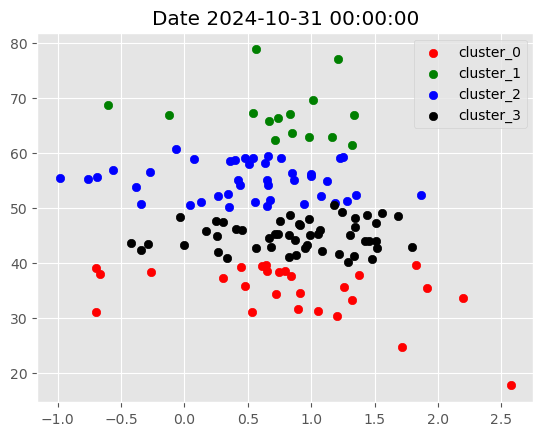

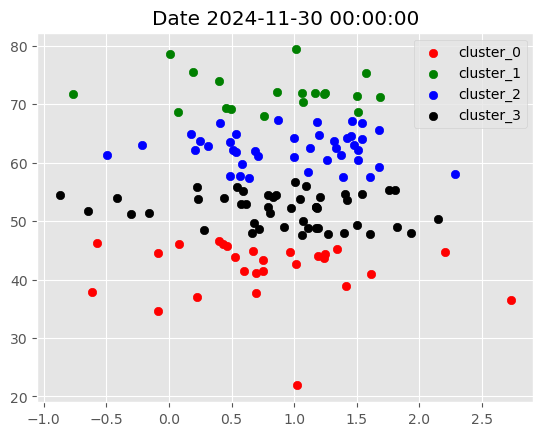

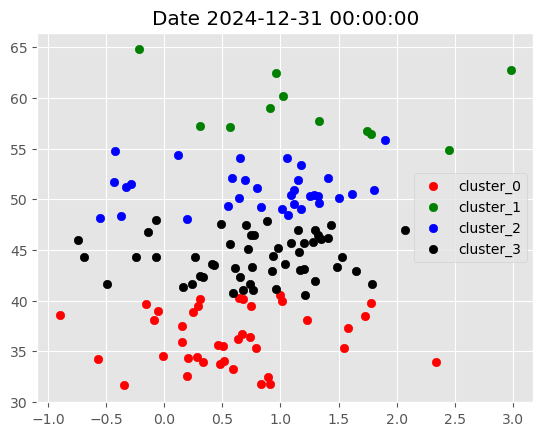

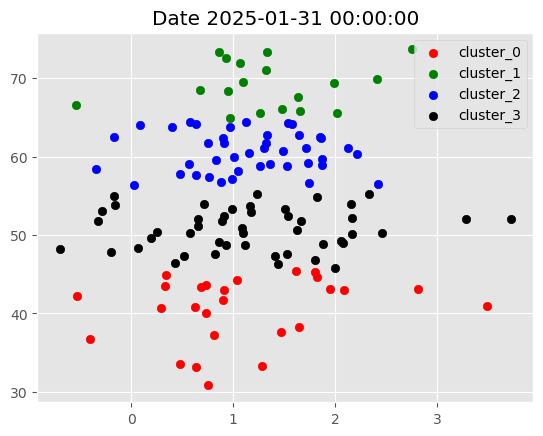

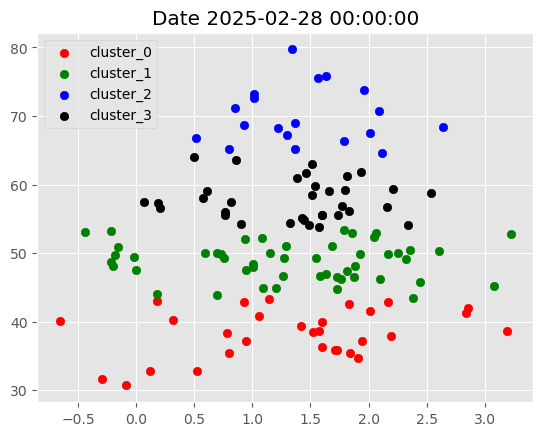

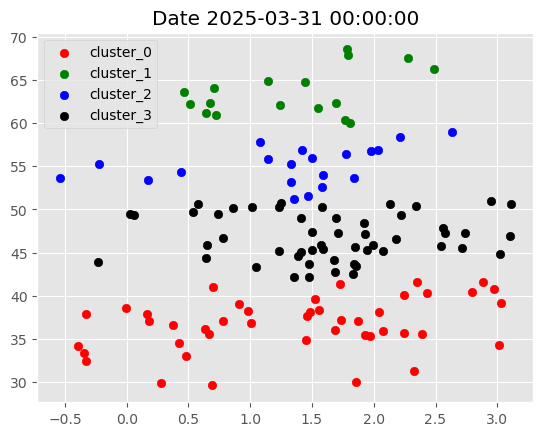

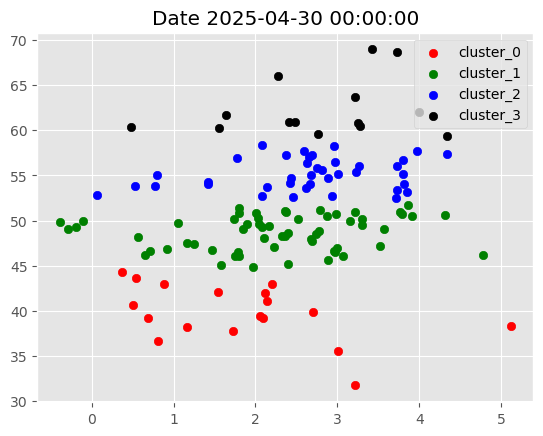

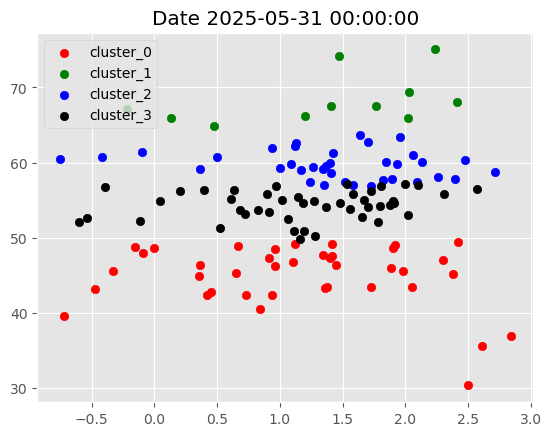

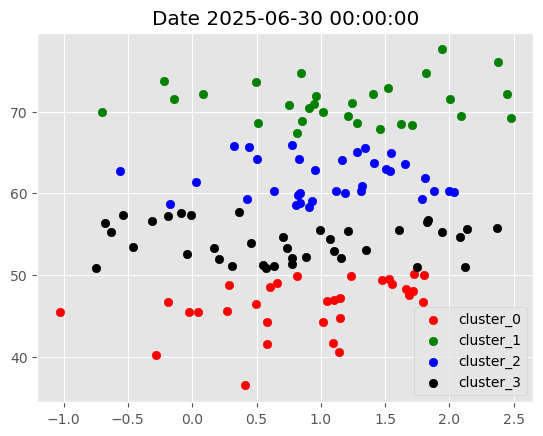

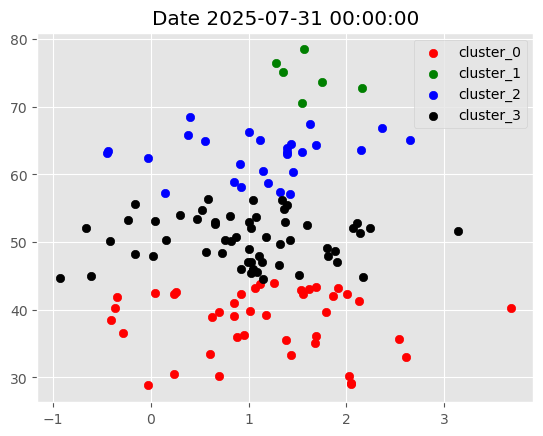

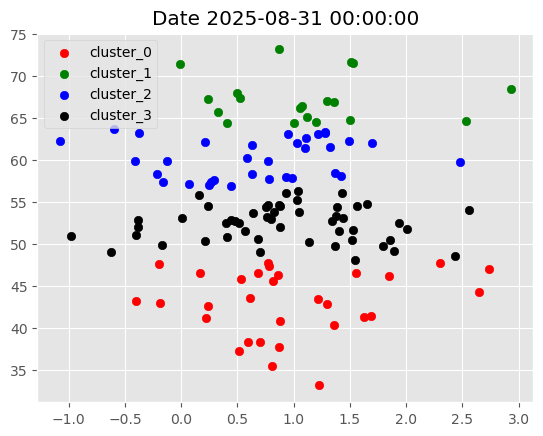

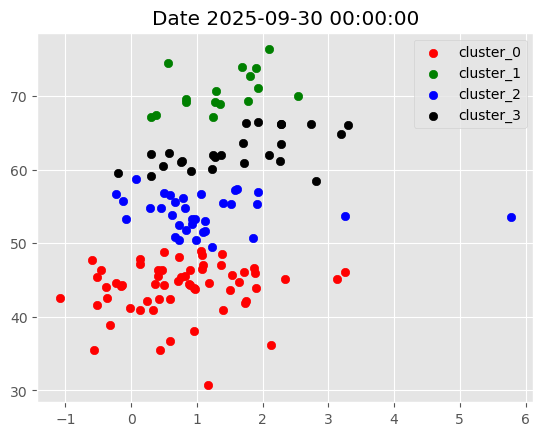

In [48]:
plt.style.use('ggplot')

for i in data.index.get_level_values('Date').unique().to_list()[-12:]:
    data_plot = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(data_plot)


# data.groupby(level=0, group_keys=False).apply(plot_clusters)

## Selecting entries with good momentum based on this clustering

In [49]:
high_moment_list = data[data['cluster']==3].copy()

In [50]:
high_moment_list = high_moment_list.reset_index(level=1)
high_moment_list.index += pd.DateOffset(1) 
high_moment_list = high_moment_list.set_index('Symbol', append=True)
high_moment_list

garman-klass volatility        rsi  bband_low  bband_mid  \
Date       Symbol                                                             
2018-02-01 ABBV                   0.000575  62.305751   4.199333   4.334643   
           ACN                    0.000023  63.135514   4.938063   4.962124   
           AIG                    0.000065  63.114240   3.893112   3.943652   
           AMGN                   0.000479  53.080999   4.944564   5.001279   
           AXP                    0.000057  53.733260   4.489116   4.509300   
...                                    ...        ...        ...        ...   
2025-10-01 NVDA                   0.000276  61.165184   5.119024   5.175707   
           PANW                   0.000207  60.064619   5.258319   5.305309   
           PFE                    0.001024  59.552368   3.175832   3.213520   
           PLTR                   0.000178  62.034836   5.025498   5.144013   
           UNH                    0.000196  62.199598   5.737596   5.825077   

                   bband_high    atr_14      macd  return_1m  return_2m  \
Date       Symbol                                                         
2018-02-01 ABBV      4.469953  0.398353  1.611780   0.168700   0.079892   
           ACN       4.986186 -1.027921  0.350293   0.049709   0.041987   
           AIG       3.994192 -0.940278  0.836622   0.072843   0.035257   
           AMGN      5.057994 -0.559264  0.787658   0.069868   0.029150   
           AXP       4.529483 -0.892709 -0.182322   0.004438   0.010389   
...                       ...       ...       ...        ...        ...   
2025-10-01 NVDA      5.232390  2.265138  0.786625   0.071251   0.024220   
           PANW      5.352299  1.223769  1.763441   0.068759   0.083017   
           PFE       3.251208 -0.206745 -0.238026   0.029079   0.045960   
           PLTR      5.262528  2.098937  1.787047   0.164061   0.073315   
           UNH       5.912557  0.576292  1.642353   0.121369   0.154006   

                   return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
Date       Symbol                                                          
2018-02-01 ABBV     0.077893   0.080351   0.063580    0.054846  0.632574   
           ACN      0.041220   0.039210   0.032852    0.030836  1.993044   
           AIG     -0.001796  -0.002169   0.007121    0.001285  1.053586   
           AMGN     0.022512   0.013012   0.016924    0.016757  2.193669   
           AXP      0.014551   0.027226   0.026761    0.023494  1.025401   
...                      ...        ...        ...         ...       ...   
2025-10-01 NVDA     0.057028   0.094784   0.037241    0.036459  2.658399   
           PANW    -0.001664   0.029888   0.012575    0.014705  0.793858   
           PFE      0.022584   0.006943   0.001336   -0.004947  0.712815   
           PLTR     0.101973   0.137073   0.102774    0.141679  0.420269   
           UNH      0.036585  -0.064998  -0.039661   -0.041226  0.166949   

                        SMB       HML       RMW       CMA  cluster  
Date       Symbol                                                   
2018-02-01 ABBV    1.828984 -0.258334 -0.106765 -0.862480        3  
           ACN    -0.577985 -0.002840 -0.855323 -0.348947        3  
           AIG    -0.718839  1.079976 -1.484496 -1.111606        3  
           AMGN    0.438301 -0.704281 -1.617744 -0.024879        3  
           AXP    -0.124939  0.875045 -0.221773 -0.476239        3  
...                     ...       ...       ...       ...      ...  
2025-10-01 NVDA   -0.718637 -1.218713  1.462613  1.328834        3  
           PANW   -1.195176  0.297338 -1.457262  0.620772        3  
           PFE     0.372921  0.456716  1.306958 -0.419046        3  
           PLTR    0.443249 -2.256041 -3.781345 -2.842207        3  
           UNH     0.441605  2.006047  0.707300 -1.750030        3  

[4332 rows x 19 columns]

In [51]:
stock_date_dict = {}
for date in high_moment_list.index.get_level_values('Date').unique().tolist():
    stock_date_dict[date.strftime('%Y-%m-%d')] = high_moment_list.xs(date, level=0).index.tolist()

## Optimizing the weights and sharp ratios:

In [52]:
from pypfopt .efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def calculate_weight(prices, lower_bound):
    returns = expected_returns.mean_historical_return(prices = prices, frequency = 252)
    cov = risk_models.sample_cov(prices = prices, frequency = 252)
    ef = EfficientFrontier(
                           expected_returns= returns,
                           cov_matrix=cov,  
                           weight_bounds=(lower_bound, .1), 
                           solver='SCS')
    weights = ef.max_sharpe()
    return ef.clean_weights()

In [53]:
stock_list = data.index.get_level_values('Symbol').unique().tolist()

In [54]:
# Yahoo Source
start_date = data.index.get_level_values('Date')[0] - pd.DateOffset(months = 12)
end_date = data.index.get_level_values('Date')[-1]

new_data = yf.download(tickers=stock_list, 
                             start=start_date,
                             end=end_date).stack()
new_data.index = new_data.index.set_names(['Date', 'Symbol'])



[*********************100%***********************]  188 of 188 completed


In [55]:
returns_dataframe = np.log(new_data['Close']).diff()/200

print(returns_dataframe)

portfolio_df = pd.DataFrame()

for start_date in stock_date_dict.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = stock_date_dict[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        
        
        optimization_df = new_data[optimization_start_date:optimization_end_date]['Close'].unstack()[cols].stack().to_frame('Close').unstack()
    
        flag = False
        try:
            weights = calculate_weight(prices = optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
        
        except:
            flag = True
            print("No feasible solution for the max sharp, selcting equal weights for all stocks") 
        
        if(flag):
          
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))], index=[col[1] for col in optimization_df.columns],
                                columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        
        temp_df = temp_df.to_frame('return').reset_index(level=0)\
                    .merge(weights.stack().rename(columns={'Close': 'weight'}).reset_index(level=0, drop=True), left_index = True, right_index=True).reset_index().set_index(['Date', 'Symbol'])
           

        temp_df.index_names = ['Date', 'Symbol']

        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    except Exception as e:
        print(e)

Date        Symbol
2017-01-31  AAPL           NaN
            ABBV      0.002069
            ABT      -0.000849
            ACN       0.005110
            ADBE      0.000669
                        ...   
2025-09-29  WMT       0.001011
            WYNN      0.001253
            XOM      -0.000740
            XYZ      -0.002077
            ZTS       0.003186
Name: Close, Length: 403243, dtype: float64
No feasible solution for the max sharp, selcting equal weights for all stocks
Series.rename() got an unexpected keyword argument 'columns'
No feasible solution for the max sharp, selcting equal weights for all stocks
Series.rename() got an unexpected keyword argument 'columns'


In [56]:
spy = yf.download(tickers='SPY',
                  start='2018-01-01',
                  end=dt.date.today())

[*********************100%***********************]  1 of 1 completed


In [57]:
spy_ret = np.log(spy['Close']).diff().dropna().rename({'SPY': 'SPY Buy&Hold'}, axis=1)
merge_comp = portfolio_df.merge(spy_ret, left_index=True, right_index=True)
merge_comp

,Strategy return,SPY Buy&Hold
Date,,
2018-02-01,0.001654,-0.001136
2018-02-02,0.001689,-0.022011
2018-02-05,0.001680,-0.042722
2018-02-06,0.001644,0.019511
2018-02-07,0.001667,-0.005440
...,...,...
2025-09-23,0.002639,-0.005458
2025-09-24,0.002644,-0.003187
2025-09-25,0.002644,-0.004624


<Axes: xlabel='Date'>

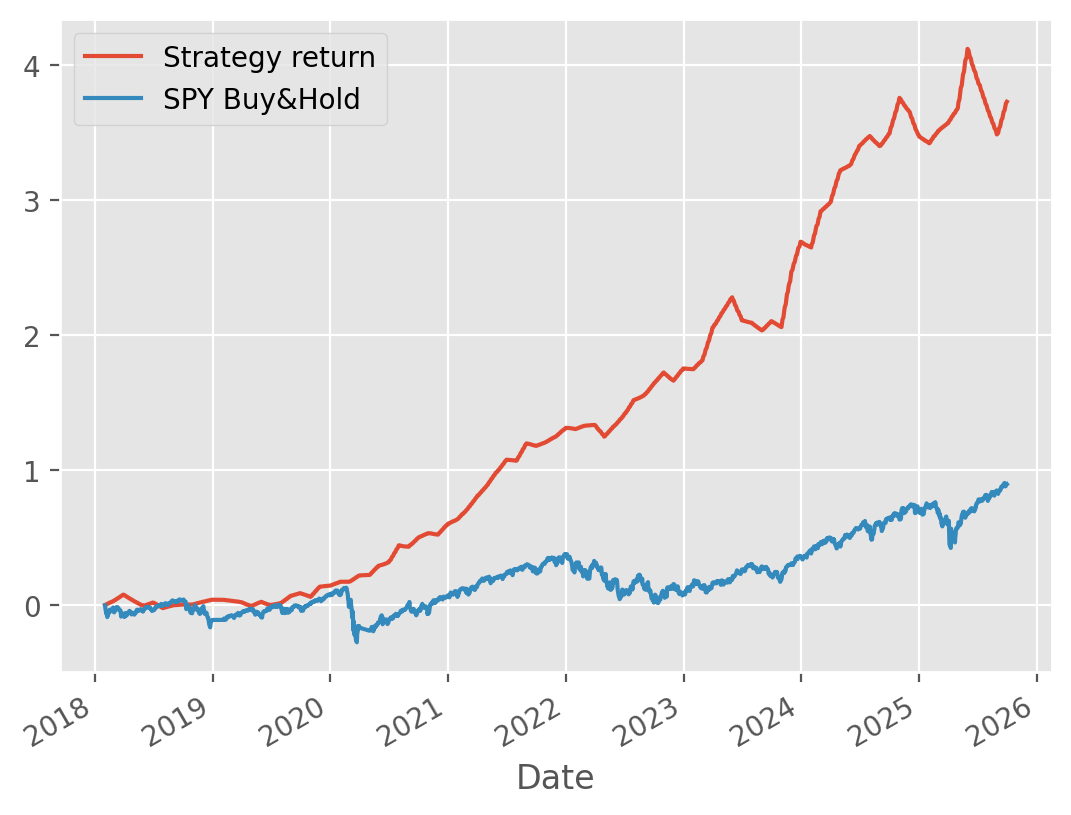

In [59]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(merge_comp).cumsum())-1
portfolio_cumulative_return.plot()